
# Contoso Product Analysis
Authored by: [Waleed](https://www.linkedin.com/in/waleedabdulla/)

## Objectives
- Provide a __Managerial Overview__ of the revenue breakdown by products' features.
- __Rank__ products based on their __quantity sold, on their revenue and both quantity sold and revenue__.
- Based on revenue, show the best products, in each best model for each best subcategory in each category in each region.
- Conduct __Market Basket Analysis__ and show list of the products that are usually sold together using __association rule__.


In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



import datetime as dt
import itertools
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error



## Data Discovery & Collection

In [9]:
# import the sales tables from folder
path = r'../data/Sales'
sales_files = glob.glob(path+'/*.csv')
sales_list = []
for file in sales_files:
    df = pd.read_csv(file, index_col = None, header= 0)
    sales_list.append(df)
sales = pd.concat(sales_list, axis = 0, ignore_index = True)
# import products table from csv file
products = pd.read_csv('../data/Contoso_Products.csv')
#import territories table from csv file
territories = pd.read_csv('../data/Contoso_Territories.csv')
# import categories table from csv file
categories = pd.read_csv('../data/Contoso_Categories.csv')
# import subcategories tbale from csv file
subcategories = pd.read_csv('../data/Contoso_Product_Subcategories.csv')
# make a list for tables
tables_list = [sales,products,territories,categories,subcategories]

# iterate over the tables-list and print info for each
for table in tables_list:
    print(table.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50466 entries, 0 to 50465
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OrderDate      50466 non-null  object
 1   StockDate      50466 non-null  object
 2   OrderNumber    50466 non-null  object
 3   ProductKey     50466 non-null  int64 
 4   CustomerKey    50466 non-null  int64 
 5   TerritoryKey   50466 non-null  int64 
 6   OrderLineItem  50466 non-null  int64 
 7   OrderQuantity  50466 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             293 non-null    int64  
 1   ProductSubcategoryKey  293 non-null    int64  
 2   ProductSKU             293 non-null    object 
 3   ProductName            293 non-null


## 3. Data Preparation

In [5]:
# pproduct= purchased product

# merge the sales dataframe with the products data frame and assign that to sales_product
df = sales.merge(
    products,left_on = 'ProductKey', right_on = 'ProductKey')

df = df.merge(
    subcategories, left_on = 'ProductSubcategoryKey', right_on = 'ProductSubcategoryKey')

df = df.merge(territories, left_on = 'TerritoryKey', right_on='SalesTerritoryKey')

df = df[df['Country']=='United States']

df = df[df['ProductName'] == 'Mountain-200 Black, 46']

df['Revenue'] = df['OrderQuantity']*df['ProductPrice']

ts_demand_forecasting= df[['OrderDate','Revenue']].copy()

In [6]:
ts_demand_forecasting.head()

,OrderDate,Revenue
938,7/30/2015,2049.0982
939,8/1/2015,2049.0982
940,8/22/2015,2049.0982
941,10/18/2015,2049.0982
942,11/10/2015,2049.0982


In [16]:
ts_demand_forecasting['OrderDate'] = pd.to_datetime(ts_demand_forecasting['OrderDate'])
ts_demand_forecasting.set_index('OrderDate', inplace=True)
ts_demand_forecasting.sort_index(inplace=True)
ts_demand_forecasting = ts_demand_forecasting.resample('M').sum()
# ts_demand_forecasting = ts_demand_forecasting.asfreq('d')
print(len(ts_demand_forecasting))
ts_demand_forecasting.tail()

24


,Revenue
OrderDate,
2017-02-28,22540.0802
2017-03-31,22540.0802
2017-04-30,22540.0802
2017-05-31,43031.0622
2017-06-30,38932.8658


In [ ]:
print(ts_demand_forecasting.describe())
plt.figure(figsize = (14,4), facecolor='lightblue')
plt.suptitle('Monthly Revenue Distribution of Mountain-200 Black, 46')
plt.subplot(1,2,1)
sns.histplot(data = ts_demand_forecasting, x = 'Revenue')

plt.subplot(1,2,2)
sns.boxplot(data = ts_demand_forecasting, x = 'Revenue')


plt.show()

In [ ]:
ts_demand_forecasting.plot(figsize=(14,4),title='Monthly Revenue Timeline of Mountain-200 Black, 46',legend=False);

## Checking the Seasonality of the Time Series

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)
seasonal_decompose(ts_demand_forecasting['Revenue']).plot()
plt.show()
plt.close()

It can be seen that this data has both trend and seasonality components

## Checking the Stationarity of the Time Series

In [ ]:
t_stat,p_value,lags, observation_num,t_critical_vals,ic = sts.adfuller(ts_demand_forecasting)
print('P_value: ',p_value)
if p_value <= 0.05:
    print('There is a significant evidence that this time series is stationary')
else:
    print('There is no significant evidence that this time series is stationary')

So, this time series is not stationariy. Therefore, I cannot use AR or MA average models. Since the data has a seasonalit component, I'll use SARIMAX model in this case.

### Determining p,d,q parameters values

__Determining d value__

In [17]:
from pmdarima.arima.utils import ndiffs

In [18]:
# determine the number of differencing to make the time series stationary
diff_num = ndiffs(ts_demand_forecasting['Revenue'])
diff_num

So, only one differencing order is needed to make the time series stationary

In [17]:
ts_diff = ts_demand_forecasting.diff(1)[1:]
ts_diff.rename(columns={'Revenue':'Difference in Revenue'}, inplace=True)
ts_diff.head()

,Difference in Revenue
OrderDate,
2015-08-31,4098.1964
2015-09-30,2049.0982
2015-10-31,-6147.2946
2015-11-30,8196.3928
2015-12-31,6147.2946


__Checking the stationarity of the New Time Series__

In [19]:
t_stat,p_value,lags, observation_num,t_critical_vals,ic = sts.adfuller(ts_diff)
print('P_value: ',p_value)
if p_value <= 0.05:
    print('There is a significant evidence that this time series is stationary')
else:
    print('There is no significant evidence that this time series is stationary')

P_value:  3.579774312896699e-10
There is a significant evidence that this time series is stationary


So d = 1

__Determining P__

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


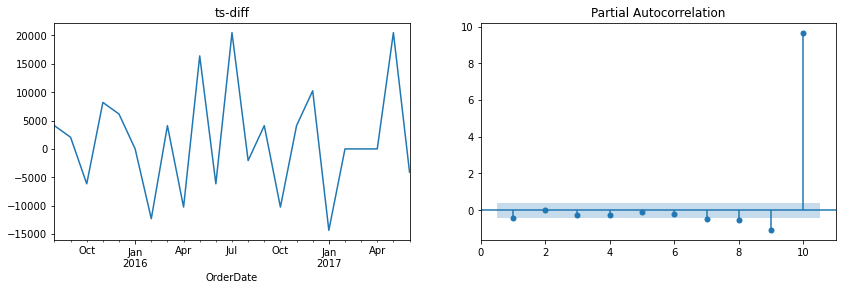

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))

ts_diff.plot(ax = ax1, title = 'ts-diff', legend = False)
sgt.plot_pacf(ts_diff,zero=False, lags=10, ax = ax2)
plt.show()
plt.close()

So, p = 10

__Dtermining q__

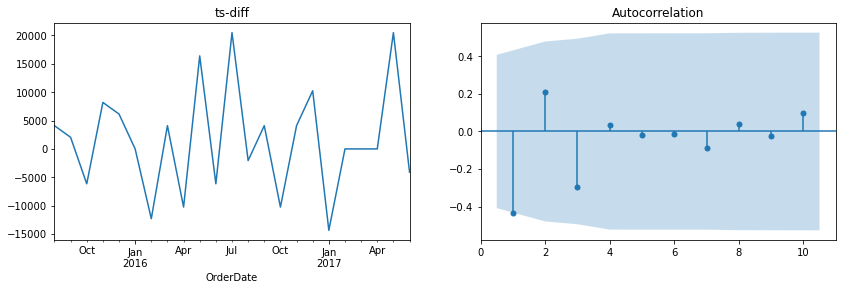

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))

ts_diff.plot(ax = ax1, title = 'ts-diff', legend = False)
sgt.plot_acf(ts_diff,zero=False, lags=10, ax = ax2)
plt.show()
plt.close()

So, q=1. However, fomr my experience, it would be better to loop over a combination of p,d,q starting from 0 to 10 and check each model with each combination, then select the model with the lowest AIC.

In [39]:
size  = len(ts_demand_forecasting)
x_train = ts_demand_forecasting.values[:int(0.8*size)]
x_test = ts_demand_forecasting.values[:int(0.2*size)]

In [49]:
p=d=q=P=D=Q= range(0,10)
S=12
pdqPDQ = list(itertools.product(p,d,q,P,D,Q))

arima_order = [(x[0],x[1],x[2]) for x in pdqPDQ]
seasonal_order = [(x[3],x[4],x[5],S) for x in pdqPDQ]

result_df = pd.DataFrame(columns =['pdq','PDQ','AIC'])

for param in pdqPDQ:
    try:
        sarimax_model = sm.tsa.statespace.SARIMAX(ts_demand_forecasting,
                                              order = arima_order[i],
                                              seasonal_order = seasonal_order[i])
        result = sarimax_model.fit()
    
        result_df.loc[i,'pdf'] = (arima_order[i][0],arima_order[i][1],arima_order[i][2])
        result_df.loc[i,'PDQ'] = (seasonal_order[i][0],seasonal_order[i],[1],seasonal_order[i][2])
        result_df.loc[i,'AIC'] = result.AIC
    
    except:
        continue

In [19]:
x = range(10)

In [21]:
for i in x:
    print(i)

0
1
2
3
4
5
6
7
8
9


## Splitting the Data

In [40]:
size = int(len(ts_demand_forecasting)*0.8)
ts_demand_forecasting_train = ts_demand_forecasting.iloc[:size]
ts_demand_forecasting_test = ts_demand_forecasting.iloc[size:]

In [41]:
print(ts_demand_forecasting_train.head())
print(ts_demand_forecasting_test.head())


                Revenue
OrderDate              
2015-01-04   64840.6564
2015-01-11  119506.3428
2015-01-18  140441.1228
2015-01-25  127818.5410
2015-02-01  114472.0974
                Revenue
OrderDate              
2017-01-01  296193.7459
2017-01-08  254234.0533
2017-01-15  281858.0228
2017-01-22  244616.4160
2017-01-29  285097.5397


## Ploting the Weekly Revenue

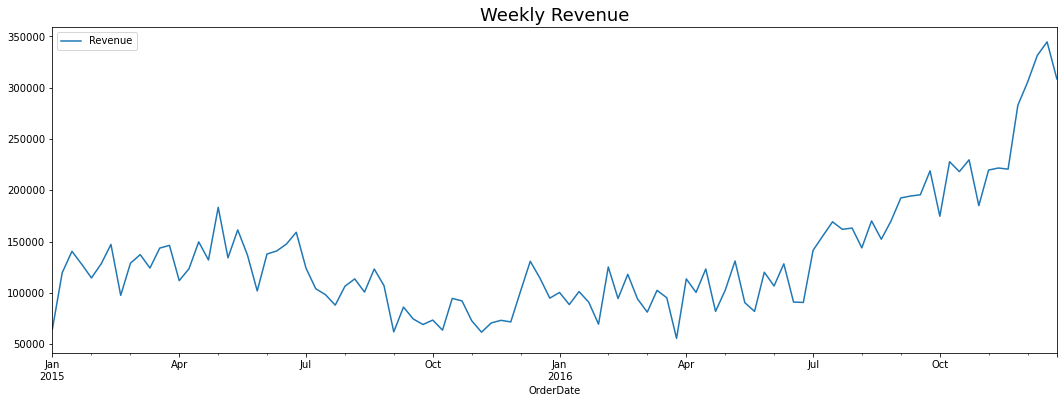

In [49]:
ts_demand_forecasting_train.plot(figsize = (18,6) )
plt.title('Weekly Revenue',size = 18)
plt.show()

## Checking Stationarity

In [53]:
_,p_value,_,_,_,_= sts.adfuller(ts_demand_forecasting_train)
print('p_value: ',p_value)
if p_value >= 0.05:
    print('Non Stationary')
else:
    print(Stationary)

p_value:  0.9980696400015208
Non Stationary


## Checking Seasonality

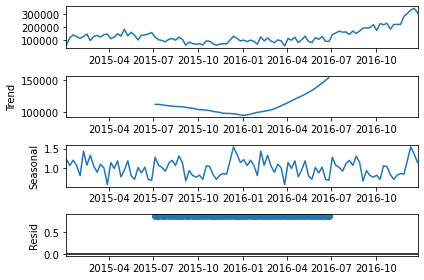

In [70]:
ts_demand_forecasting_train_muliplicative = seasonal_decompose(ts_demand_forecasting_train,
                                                               model = 'muliplicative')
trend = ts_demand_forecasting_train_muliplicative.trend
seasonal = ts_demand_forecasting_train_muliplicative.seasonal
residual = ts_demand_forecasting_train_muliplicative.resid

ts_demand_forecasting_train_muliplicative.plot()

plt.show()

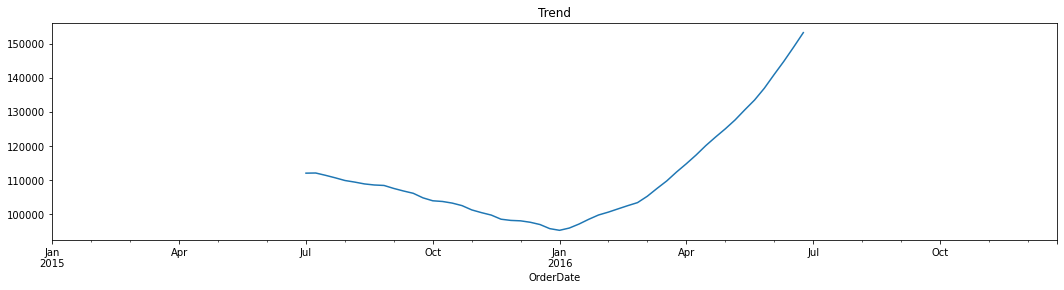

In [72]:
trend.plot(figsize=(18,4),title='Trend')
plt.show()

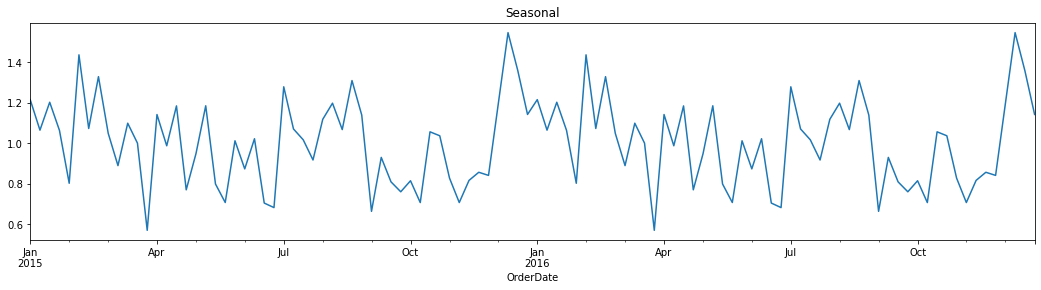

In [73]:
seasonal.plot(figsize=(18,4),title='Seasonal')
plt.show()

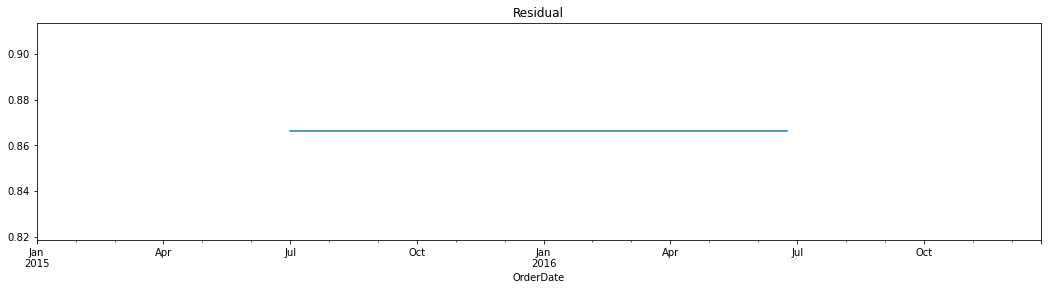

In [74]:
residual.plot(figsize=(18,4), title = 'Residual')
plt.show()

## ACF

<Figure size 432x288 with 0 Axes>

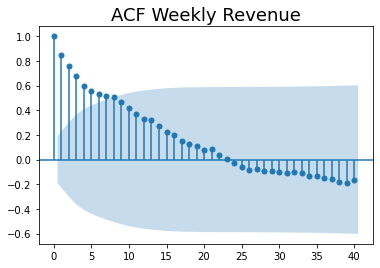

In [77]:

sgt.plot_acf(ts_demand_forecasting_train, lags = 40, zero = True)
plt.title('ACF Weekly Revenue', size = 18)
plt.show()

## PACF

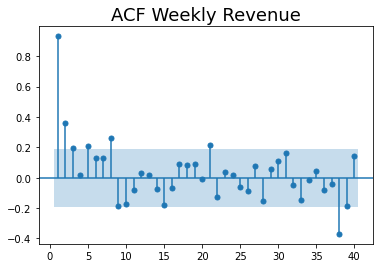

In [78]:
sgt.plot_pacf(ts_demand_forecasting_train, lags = 40, zero = False, method = ('ols'))
plt.title('ACF Weekly Revenue', size = 18)
plt.show()

In [49]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')